In [1]:
import pandas as pd
import numpy as np
import arima
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/pars_normal_daily.csv", index_col=0)
df.head()


,mu,sigma
2021-12-01,-0.000060,0.000530
2021-12-02,0.000039,0.000643
2021-12-03,-0.000022,0.000703
2021-12-06,0.000030,0.000565
2021-12-07,0.000053,0.000659


In [65]:
# Check for stationarity
arima.adf_check(df["mu"])
arima.adf_check(df["sigma"])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.380010424707947
p-value : 2.2343714059272166e-08
Number of Lags Used : 1
Number of Observations Used : 67
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.020289290202549
p-value : 0.0013079185626142368
Number of Lags Used : 0
Number of Observations Used : 68
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [66]:
idx = int(len(df)*0.8)
train, test = df.iloc[:idx], df.iloc[idx:]
train.head(), test.head()

(                  mu     sigma
 2021-12-01 -0.000060  0.000530
 2021-12-02  0.000039  0.000643
 2021-12-03 -0.000022  0.000703
 2021-12-06  0.000030  0.000565
 2021-12-07  0.000053  0.000659,
                   mu     sigma
 2022-02-18 -0.000016  0.000581
 2022-02-22 -0.000027  0.000746
 2022-02-23 -0.000046  0.000690
 2022-02-24  0.000038  0.001633
 2022-02-25  0.000056  0.000609)

In [79]:
def AR(p, df, key):
    '''
    Generating the lagged p terms
    '''
    df_temp = df

    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp[key].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_val = pd.DataFrame(df_temp[train_size:df_temp.shape[0]])
    
    print("df_train")
    print(df_train)
#     print("df_val")
#     print(df_val)

    df_train_2 = df_train.dropna()
#     print("df_train_2")
#     print(df_train_2)

    print(df_train_2)
    print("Reshaped")
#     print(df_train_2.iloc[:,1:].values.reshape(-1,p))
    #X contains the lagged values ,hence we skip the first column
    try:
        print("Trying...")
        X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    except:
        print("Failed.")
        return [pd.DataFrame(), pd.DataFrame(), 0, 0, float("inf")]
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,1].values.reshape(-1,1)
    
    print("X_train")
    print(X_train)
    print("y_train")
    print(y_train)

    #Running linear regression to generate the coefficents of lagged terms
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_val = df_val.iloc[:,1:].values.reshape(-1,p)
    df_val['Predicted_Values'] = X_val.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_val[key], df_val['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_val,theta,intercept,RMSE]

In [88]:
pd.DataFrame(df.mu)

,mu
2021-12-01,-0.000060
2021-12-02,0.000039
2021-12-03,-0.000022
2021-12-06,0.000030
2021-12-07,0.000053
...,...
2022-03-04,-0.000021
2022-03-07,-0.000076
2022-03-08,-0.000020
2022-03-09,0.000068


In [82]:
df_train_2, df_test, theta, intercept, RMSE = arima.AR(10, pd.DataFrame(df.mu), 'mu')

The RMSE is : 5.693034563916318e-05 , Value of p :  10


/Users/eliaslittle/School/CDS/Stock-Densities/arima.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


In [89]:
df_c = pd.concat([df_train_2, df_test])
res = pd.DataFrame()
res['Residuals'] = df_c.mu - df_c.Predicted_Values

In [91]:
res.head()

,Residuals
2021-12-15,0.000057
2021-12-16,-0.000062
2021-12-17,-0.000014
2021-12-20,0.000010
2021-12-21,0.000071


/Users/eliaslittle/School/CDS/Stock-Densities/arima.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


The RMSE is : 4.78636927718186e-05 , Value of q :  10


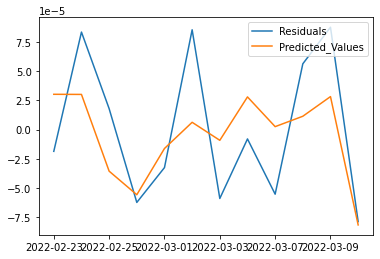

In [92]:
res_train_2,res_val,theta,intercept,RMSE = arima.MA(10, res)

<AxesSubplot:>

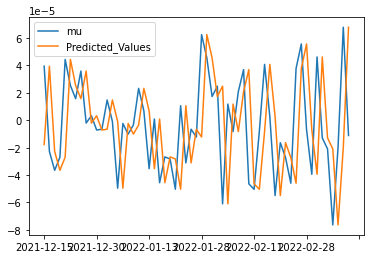

In [96]:
df_c = pd.concat([df_train_2, df_test])

df_c[['mu','Predicted_Values']].plot()

In [100]:
df_c = pd.concat([df_train_2,df_test])
res['Residuals'] = df_c.mu - df_c.Predicted_Values

In [102]:
res_c = pd.concat([res_train_2,res_val])
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Predicted_Values
2021-12-30,-1.039796e-05,5.311477e-06,-3.793719e-05,2.014098e-05,-9.575410e-06,-1.904102e-05,7.135092e-05,9.561244e-06,-1.372941e-05,-6.225131e-05,5.714451e-05,-8.505769e-06
2021-12-31,5.829729e-07,-1.039796e-05,5.311477e-06,-3.793719e-05,2.014098e-05,-9.575410e-06,-1.904102e-05,7.135092e-05,9.561244e-06,-1.372941e-05,-6.225131e-05,2.333388e-05
2022-01-03,2.132850e-05,5.829729e-07,-1.039796e-05,5.311477e-06,-3.793719e-05,2.014098e-05,-9.575410e-06,-1.904102e-05,7.135092e-05,9.561244e-06,-1.372941e-05,5.440788e-06
2022-01-04,-1.560674e-05,2.132850e-05,5.829729e-07,-1.039796e-05,5.311477e-06,-3.793719e-05,2.014098e-05,-9.575410e-06,-1.904102e-05,7.135092e-05,9.561244e-06,-2.462319e-05
2022-01-05,-4.876436e-05,-1.560674e-05,2.132850e-05,5.829729e-07,-1.039796e-05,5.311477e-06,-3.793719e-05,2.014098e-05,-9.575410e-06,-1.904102e-05,7.135092e-05,-9.329838e-06
2022-01-06,4.723294e-05,-4.876436e-05,-1.560674e-05,2.132850e-05,5.829729e-07,-1.039796e-05,5.311477e-06,-3.793719e-05,2.014098e-05,-9.575410e-06,-1.904102e-05,3.431992e-05
2022-01-07,-7.784205e-06,4.723294e-05,-4.876436e-05,-1.560674e-05,2.132850e-05,5.829729e-07,-1.039796e-05,5.311477e-06,-3.793719e-05,2.014098e-05,-9.575410e-06,7.408181e-06
2022-01-10,6.686652e-06,-7.784205e-06,4.723294e-05,-4.876436e-05,-1.560674e-05,2.132850e-05,5.829729e-07,-1.039796e-05,5.311477e-06,-3.793719e-05,2.014098e-05,4.937164e-06
2022-01-11,2.671154e-05,6.686652e-06,-7.784205e-06,4.723294e-05,-4.876436e-05,-1.560674e-05,2.132850e-05,5.829729e-07,-1.039796e-05,5.311477e-06,-3.793719e-05,1.675701e-05
2022-01-12,-1.648881e-05,2.671154e-05,6.686652e-06,-7.784205e-06,4.723294e-05,-4.876436e-05,-1.560674e-05,2.132850e-05,5.829729e-07,-1.039796e-05,5.311477e-06,-4.067741e-05


In [103]:
df_c.Predicted_Values += res_c.Predicted_Values

<AxesSubplot:>

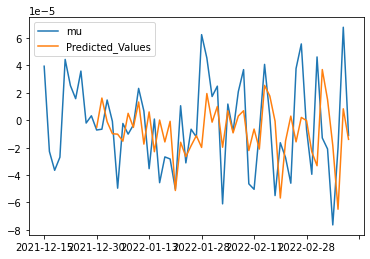

In [104]:
df_c[['mu','Predicted_Values']].plot()

The RMSE is : 5.693034563916318e-05 , Value of p :  10
The RMSE is : 4.78636927718186e-05 , Value of q :  10


/Users/eliaslittle/School/CDS/Stock-Densities/arima.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
/Users/eliaslittle/School/CDS/Stock-Densities/arima.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


<AxesSubplot:>

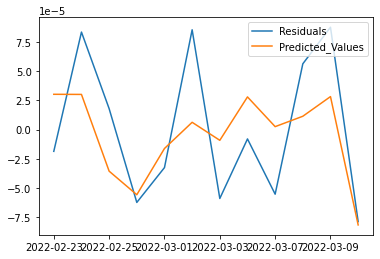

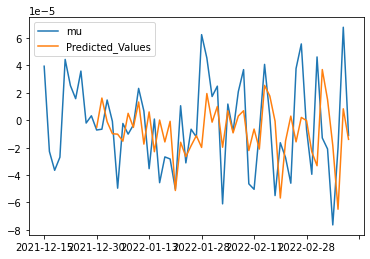

In [7]:
results = arima.arima(10,10,pd.DataFrame(df.mu), 'mu')
results[0][['mu','Predicted_Values']].plot()

<AxesSubplot:>

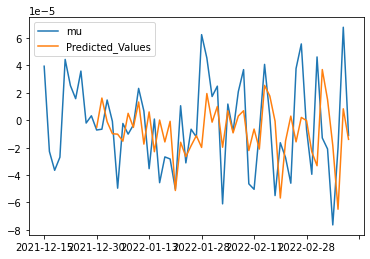